In [193]:
from model import Model
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## **Data Preparation**

In [194]:
# Read in data
img_size = 128
data_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size)
])

dataset = datasets.ImageFolder(root='lung_colon_image_set', transform=data_transformation)

In [195]:
dataset.class_to_idx

{'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}

In [196]:
# Set up train and test data
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = int(0.15 * len(dataset))
train_data, valid_data, test_data = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

batch_size = 32  
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

len(train_data), len(valid_data), len(test_data)

(17500, 3750, 3750)

In [197]:
# 'Colon Adenocarcinoma', 'Colon Benign', 'Lung Adenocarcinoma', 'Lung Benign', 'Lung Squamous Cell Caricnoma'
classes = ('colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc')
# The function to show an image.
def display_img(ax, img, label):
    img = img / 2 + 0.5     # Unnormalize.
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0))) # Convert to (H,W,C)
    ax.set_title(classes[label])
    ax.axis('off')

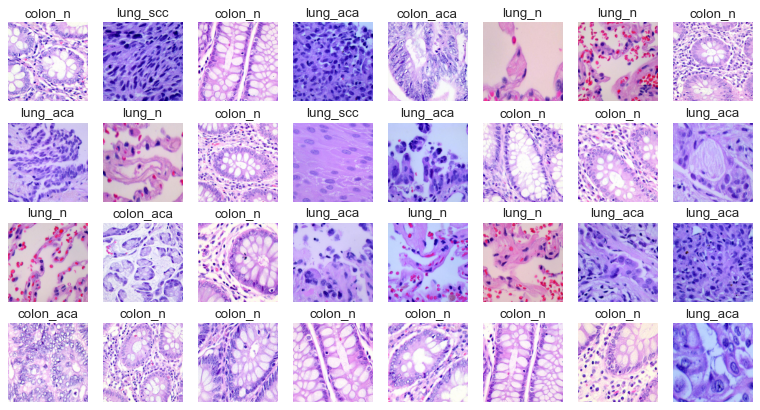

In [198]:
plt.figure(figsize=(12, 6))

# Get a random batch of training images.
images, labels = next(iter(train_loader))

for i in range(batch_size):
    ax = plt.subplot(4, 8, i+1)  # Create a subplot for each image
    display_img(ax, images[i], labels[i])

In [141]:
# Set up device
if torch.backends.mps.is_available(): # M1 Mac
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device)  

mps


## **Set Up Training and Validation Steps**

In [142]:
def validateNN(network, valid_loader, loss_function):
    #print('Validating Model...')
    network.eval()  # Set the network to evaluation mode
    total_loss = 0.0
    total_batches = 0
    with torch.no_grad():  # No gradients needed
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to the specified device
            outputs = network(inputs)  # Forward step
            loss = loss_function(outputs, labels)  # Calculate loss

            total_loss += loss.item()
            total_batches += 1
    
    validation_avg_loss = total_loss / total_batches
    network.train() # Set the network back to training mode
    return validation_avg_loss

In [143]:
def train_validateCNN(network, train_loader, loss_function, optimizer, epochs, print_freq=50):
    print('Training Model...')
    train_epoch_losses = [] # Track training loss per epoch
    valid_epoch_losses = []  # Track validation loss per epoch
    
    for epoch in range(epochs):  # Loop over the dataset multiple times.
        mini_batch_loss = 0.0       # Initialize running loss within epoch
        total_loss = 0.0         # For calculating avg loss per epoch
        total_batches = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device) # Move the inputs to the specified device.
            optimizer.zero_grad() # Zero the parameter gradients.
            
            outputs = network(inputs) # Forward step.
            loss = loss_function(outputs, labels)
            loss.backward() # Backward step.
            optimizer.step() # Optimization step (update the parameters).

            # Track losses
            mini_batch_loss += loss.item()
            total_loss += loss.item()
            total_batches += 1

            # Print average loss for every 'print_freq' mini-batches within Epoch
            if i % print_freq == print_freq - 1: 
                print('[Epoch: {}/{}, i: {:5d}]: Average mini-batch loss: {:.3f}'.format(epoch+1, epochs, i+1, mini_batch_loss / print_freq))
                mini_batch_loss = 0.0
        avg_train_loss = total_loss / total_batches
        train_epoch_losses.append(avg_train_loss)

        # Validate after each Epoch
        avg_valid_loss = validateNN(network, valid_loader, loss_function)
        valid_epoch_losses.append(avg_valid_loss)
        
        print('End of Epoch {} - Average train loss: {:.4f}, Average validation loss: {:.4f}'.format(epoch+1, avg_train_loss, avg_valid_loss))

    print('Finished Training.')
    return train_epoch_losses, valid_epoch_losses
    

In [144]:
# I'm not sure the best way to do this, feel free to edit 

# def display_model_performance(train_loss, valid_loss):
#     plt.figure(figsize=(10,8))
#     plt.style.use('fivethirtyeight')
#     plt.plot(train_loss, 'red', label = 'Training Loss')
#     plt.plot(valid_loss, 'green', label='Validation Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Average Epoch Loss')
#     plt.title('Training and Validation Loss by Epoch')
#     plt.legend()
#     plt.show()

### ReLU + MaxPool

In [145]:
# We use cross-entropy as loss function; Adam as optimizer
reluMaxPool_CNN = Model('relu', 'max', img_size, elu_val = 1, lrelu_val = 0.01)
reluMaxPool_CNN.to(device)

Model(
  (layers): Sequential(
    (0): ConvBlock(
      (act): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvBlock(
      (act): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvBlock(
      (act): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), p

In [146]:
reluMaxPool_train_loss, reluMaxPool_valid_loss = train_validateCNN(reluMaxPool_CNN, train_loader, 
                                                                   nn.CrossEntropyLoss(), optim.Adam(reluMaxPool_CNN.parameters(), lr=0.001), 11)

Training Model...
[Epoch: 1/11, i:    50]: Average mini-batch loss: 0.557
[Epoch: 1/11, i:   100]: Average mini-batch loss: 0.406
[Epoch: 1/11, i:   150]: Average mini-batch loss: 0.343
[Epoch: 1/11, i:   200]: Average mini-batch loss: 0.272
[Epoch: 1/11, i:   250]: Average mini-batch loss: 0.276
[Epoch: 1/11, i:   300]: Average mini-batch loss: 0.221
[Epoch: 1/11, i:   350]: Average mini-batch loss: 0.281
[Epoch: 1/11, i:   400]: Average mini-batch loss: 0.238
[Epoch: 1/11, i:   450]: Average mini-batch loss: 0.206
[Epoch: 1/11, i:   500]: Average mini-batch loss: 0.184
End of Epoch 1 - Average train loss: 0.2920, Average validation loss: 2.4354
[Epoch: 2/11, i:    50]: Average mini-batch loss: 0.203
[Epoch: 2/11, i:   100]: Average mini-batch loss: 0.224
[Epoch: 2/11, i:   150]: Average mini-batch loss: 0.262
[Epoch: 2/11, i:   200]: Average mini-batch loss: 0.190
[Epoch: 2/11, i:   250]: Average mini-batch loss: 0.197
[Epoch: 2/11, i:   300]: Average mini-batch loss: 0.174
[Epoch: 2

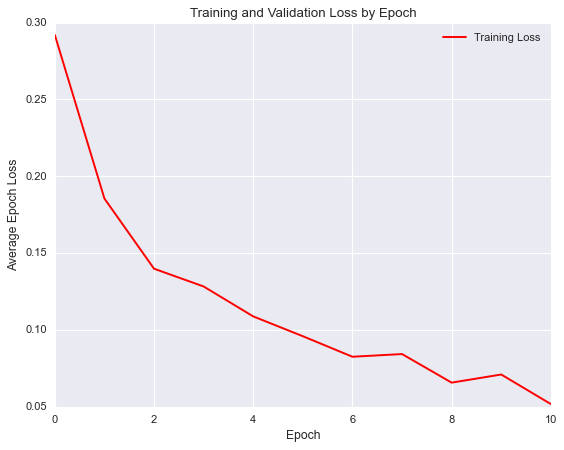

In [190]:
plt.figure(figsize=(8,6))
plt.style.use('seaborn-v0_8')
plt.plot(reluMaxPool_train_loss, 'red', label = 'Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Epoch Loss')
plt.title('Training and Validation Loss by Epoch')
plt.legend()
plt.show()

In [156]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

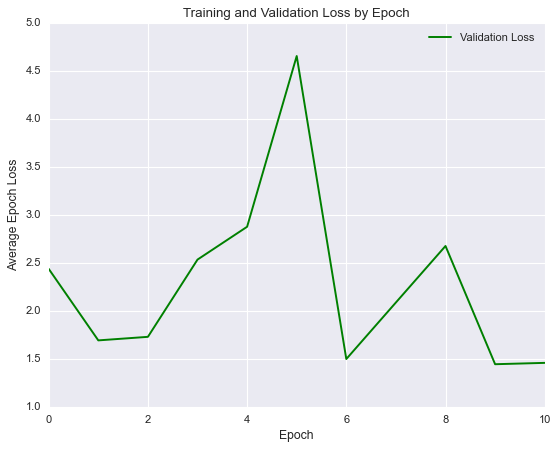

In [192]:
plt.figure(figsize=(8,6))
plt.style.use('seaborn-v0_8')
plt.plot(reluMaxPool_valid_loss, 'green', label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Epoch Loss')
plt.title('Training and Validation Loss by Epoch')
plt.legend()
plt.show()

### ReLU + AvgPool

In [123]:
reluAvgPool_CNN = Model('relu', 'avg', img_size, elu_val = 1, lrelu_val = 0.01)
reluAvgPool_CNN.to(device)

Model(
  (layers): Sequential(
    (0): ConvBlock(
      (act): ReLU()
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvBlock(
      (act): ReLU()
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvBlock(
      (act): ReLU()
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [125]:
reluAvgPool_train_loss, reluAvgPool_valid_loss = train_validateCNN(reluAvgPool_CNN, train_loader, 
                                                                   nn.CrossEntropyLoss(), optim.Adam(reluAvgPool_CNN.parameters(), lr=0.001), 8)

Training Model...
[Epoch: 1/5, i:    50]: Average mini-batch loss: 0.632
[Epoch: 1/5, i:   100]: Average mini-batch loss: 0.419
[Epoch: 1/5, i:   150]: Average mini-batch loss: 0.383
[Epoch: 1/5, i:   200]: Average mini-batch loss: 0.341
[Epoch: 1/5, i:   250]: Average mini-batch loss: 0.343
[Epoch: 1/5, i:   300]: Average mini-batch loss: 0.327
[Epoch: 1/5, i:   350]: Average mini-batch loss: 0.308
[Epoch: 1/5, i:   400]: Average mini-batch loss: 0.304
[Epoch: 1/5, i:   450]: Average mini-batch loss: 0.246
[Epoch: 1/5, i:   500]: Average mini-batch loss: 0.262
End of Epoch 1 - Average train loss: 0.3485, Average validation loss: 40.9863
[Epoch: 2/5, i:    50]: Average mini-batch loss: 0.259
[Epoch: 2/5, i:   100]: Average mini-batch loss: 0.211
[Epoch: 2/5, i:   150]: Average mini-batch loss: 0.239
[Epoch: 2/5, i:   200]: Average mini-batch loss: 0.266
[Epoch: 2/5, i:   250]: Average mini-batch loss: 0.242
[Epoch: 2/5, i:   300]: Average mini-batch loss: 0.238
[Epoch: 2/5, i:   350]: 

### LeakyReLU + MaxPool

In [ ]:
leakyRelu_MaxPool_CNN = Model('lrelu', 'max', img_size, elu_val = 1, lrelu_val = 0.01)
leakyRelu_MaxPool_CNN.to(device)

### LeakyReLU + AvgPool

In [ ]:
leakyRelu_AvgPool_CNN = Model('lrelu', 'avg', img_size, elu_val = 1, lrelu_val = 0.01)
leakyRelu_AvgPool_CNN.to(device)

### ELU + MaxPool

In [ ]:
elu_MaxPool_CNN = Model('elu', 'max', img_size, elu_val = 1, lrelu_val = 0.01)
elu_MaxPool_CNN.to(device)

### ELU + AvgPool

In [ ]:
elu_AvgPool_CNN = Model('elu', 'avg', img_size, elu_val = 1, lrelu_val = 0.01)
elu_AvgPool_CNN.to(device)

## **Evaluate on Testing Data**

## **Comparison to other popular CNN Architectures**

Any other popular architectures (feel free to edit / we can decide together)